In [1]:
import os
import datetime
import random
import warnings
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# import tensorflow_addons as tfa
#finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

In [2]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')

df_unique = df.copy()
df_unique.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
df_unique=df_unique.drop([ 'lesion_id','dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_unique = df_unique.reset_index(drop=True)
df=df.drop([ 'lesion_id','dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)

train_df, val_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx'])
train_df_unique, val_df_unique = train_test_split(df_unique, train_size=0.9, shuffle=True, random_state=123, stratify=df_unique['dx'])
df.shape, train_df.shape, val_df.shape, df_unique.shape, train_df_unique.shape, train_df_unique.shape

((10015, 2), (9013, 2), (1002, 2), (5514, 2), (4962, 2), (4962, 2))

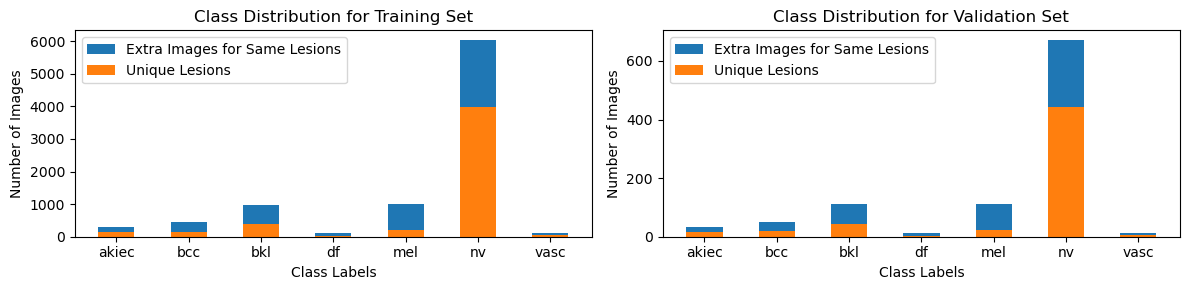

In [3]:
#plotting class distribution for lesion_id and image_id before rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(train_df['dx'].sort_values(),bins=bins)
ax1.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for val set
ax2.hist(val_df['dx'].sort_values(),bins=bins)
ax2.hist(val_df_unique['dx'].sort_values(),bins=bins)
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
#plt.savefig('class_distribution.png')
plt.show()

In [4]:
def random_augment(image):
    tf.random.set_seed(123)
    # Randomly applied horizontal flip - reasonable for skin images
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness - simulate different lighting conditions
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    # Random contrast - simulate variations in camera quality and settings
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random rotation - lesions can be oriented in any direction
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Gaussian blur - simulate slight focus variations
    # image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=1.0)
    
    return image

In [5]:
def augmentention_on_dataset(df, df_unique, dataset_type, images_directory, max_sample, min_sample, ):
    if not os.path.exists(images_directory+'_augmented'):
        os.mkdir(images_directory+'_augmented')
        
    df_unique = df_unique
    for label in df['dx'].unique():
        df_label = df[df['dx'] == label]
        df_unique_label = df_unique[df_unique['dx'] == label]
    
        #If in the label is more than n images we delete all duplicates and sometimes part of random unique imagas
        if(len(df_label) > max_sample):
            df = pd.concat([df[df['dx'] != label], df_unique[df_unique['dx'] == label]])
            df_label = df[df['dx'] == label]
            drop_indices = np.random.choice(df[df['dx'] == label].index, len(df_label) - max_sample, replace=False)
            df = pd.concat([df[df['dx'] != label], df_label.drop(drop_indices)])
        
        #If in the label is less than n images we randomly choose unique images for augmentation
        if(len(df_label) < min_sample):
            selected_indices = np.random.choice(df_unique_label.index, min_sample - len(df_label), replace=True)
            df_to_add = df_unique_label.loc[selected_indices]
            df_to_add['image_id'] = df_to_add['image_id'] + '-' + dataset_type + (df_to_add.groupby('image_id').cumcount() + 1).astype(str)
            df = pd.concat([df, df_to_add])
    
    for j in df[df['image_id'].str.len() == 12]['image_id'].values:
        # copy image without change to augmented folder
        shutil.copy(images_directory + '/'+j+'.jpg', images_directory + '_augmented'+ '/'+j+'.jpg'), 
    
            
    for i in df[df['image_id'].str.len() > 12]['image_id'].values:
        image = tf.io.read_file(os.path.join(images_directory, i.split('-')[0] + '.jpg'))
        image = tf.image.decode_jpeg(image, channels=3)
    
        # Apply augmentations
        augmented_image = random_augment(image)
    
        # Convert back to image format and save the augmented image
        augmented_image = tf.cast(augmented_image, tf.uint8)
        augmented_image = tf.image.encode_jpeg(augmented_image)
        tf.io.write_file(os.path.join(images_directory+'_augmented', i + '.jpg'), augmented_image)
    
    df['image_id'] = df['image_id'].astype(str) + '.jpg'
    df_shuffled = df.copy().sample(frac=1, random_state=123).reset_index(drop=True)
    df_shuffled.to_csv(f'dataverse_files/HAM10000_metadata_augmented_' + dataset_type +'.csv', index=False)

In [6]:
input_path = "dataverse_files/HAM10000_images_pca"
#shutil.rmtree(input_path + '_augmented') # to delete augmented folder
augmentention_on_dataset(train_df, train_df_unique, 'train_df', input_path, 1350, 720)
augmentention_on_dataset(val_df, val_df_unique, 'val_df', input_path, 150, 80)

In [7]:
train_df_unique_augmented = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_train_df.csv')
val_df_unique_augmented = pd.read_csv('dataverse_files/HAM10000_metadata_augmented_val_df.csv')
train_df_unique_augmented.head()

,image_id,dx
0,ISIC_0028926-train_df17.jpg,df
1,ISIC_0026642.jpg,nv
2,ISIC_0032655.jpg,bkl
3,ISIC_0027856-train_df2.jpg,vasc
4,ISIC_0030227.jpg,bkl


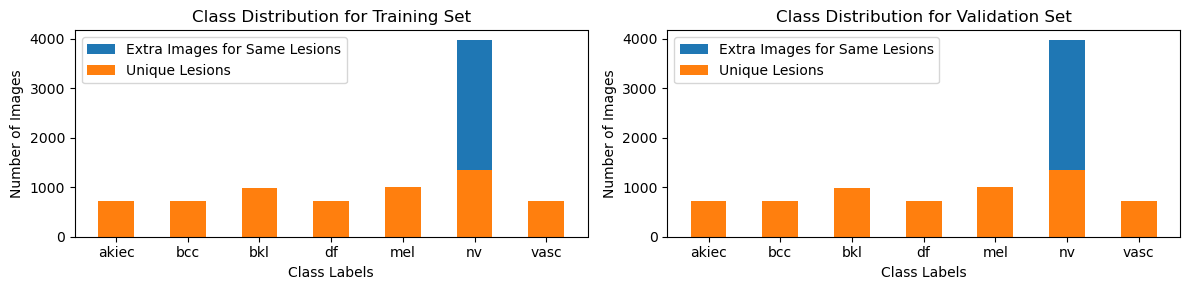

In [8]:
#plotting class distribution for lesion_id and image_id after rebalancing the class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax1.hist(train_df_unique_augmented['dx'].sort_values(),bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for val set
ax2.hist(train_df_unique['dx'].sort_values(),bins=bins)
ax2.hist(train_df_unique_augmented['dx'].sort_values(),bins=bins)
ax2.set_title("Class Distribution for Validation Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
#plt.savefig('class_distribution_augmented.png')
plt.show()